# Weather Stations & Fire Spread


## Setup

In [ ]:
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/FireDrivers_Paper" 

import os
rootPath = "/content/drive/My Drive/FireDrivers_Paper/WeatherStation_FireSpread"
os.chdir(rootPath)

/content/drive/My Drive/FireDrivers_Paper


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!grep MemTotal /proc/meminfo

MemTotal:       26751672 kB


In [ ]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import rtree

In [ ]:
import requests
import os
import re
import lxml.html as lh
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [ ]:
def lstFiles(rootPath, ext):
  '''
  retrieve file path + names based on extension
  '''
  file_list = []
  root = rootPath
  for path, subdirs, files in os.walk(root):
      for names in files: 
          if names.endswith(ext):
              file_list.append(os.path.join(path,names))
  return(file_list)

def createFolder(rootPath, folderName): 
  '''
  Create new folder in root path 
  '''
  folderPath = os.path.join(rootPath, folderName) 
  if not os.path.exists(folderPath):
      os.makedirs(folderPath)
  return folderPath 

## Obtain RAWS Station Info

In [ ]:
import re

stationName = [] 
stationAbbrv = [] 
mainURL = [] 
lat = [] 
long = [] 
startYr = [] 
endYr = [] 

# Station Name, Code, url, lat/long 
# find latest, earliest dates (Year, Month) for each station 
RegionList = ["ncalst", "ccalst", "scalst"]
root = "https://wrcc.dri.edu/"
for region in RegionList: 
    # https://wrcc.dri.edu/cgi-bin/rawMAIN.pl?nvNBLU
    # https://wrcc.dri.edu/cgi-bin/rawNAME.pl?nvNBLU
    # https://wrcc.dri.edu/cgi-bin/wea_info.pl?nvNBLU
    url = 'https://wrcc.dri.edu/wraws/'+ str(region) +'.html'
    html= urlopen(url)
    soup = BeautifulSoup(html,"lxml")
    text = soup.get_text()
    for text in soup.find_all('a', href=True):
        #print(text)
        binURL = re.search('href="(.*)" onmouseout=', str(text))
        result = re.search("> (.*)California </a>", str(text))
        if result is not None and binURL.group(1)[-3:] not in stationName:
            try: 
                #print(result.group(1), binURL.group(1), binURL.group(1)[-3:])
                dates = binURL.group(1).replace("rawMAIN", "rawNAME", 1)
                info = binURL.group(1).replace("rawMAIN", "wea_info", 1)
                datesURL = root + dates 
                infoURL =  root + info 
                #print(datesURL, infoURL)
                # get start/end dates 
                dateHtml= urlopen(datesURL)
                dateSoup = BeautifulSoup(dateHtml)
                #paragraphs = dateSoup.find_all('b')
                paragraphs = dateSoup.get_text()
                yrs = [int(s) for s in paragraphs.split() if s.isdigit() and len(s) == 4]
                #print(yrs[0], yrs[-1])
                #print(paragraphs)
                #Lat = re.search('<td><font color="#ff0000"> <b> (.*) </b>', str(paragraphs))
                datetext = dateSoup.get_text()
                infoHtml= urlopen(infoURL)
                infoSoup = BeautifulSoup(infoHtml)
                infotext = infoSoup.get_text()
                latMark = infotext.find('°') 
                latitude = infotext[latMark - 2 : latMark + 8]
                #print(latMark, infotext[latMark - 2 : latMark + 8])
                i = infotext.index('°')
                longMark = infotext.index('°', i + 1)
                #print(longMark, infotext[longMark - 3 : longMark + 8])
                longitude = infotext[longMark - 3 : longMark + 8]
                # append values to empty list 
                endYr.append(yrs[0])
                startYr.append(yrs[-1])
                lat.append(latitude)
                long.append(longitude)
                stationName.append(result.group(1))
                stationAbbrv.append(binURL.group(1)[-3:])
                mainURL.append(binURL.group(1))
            except: 
                continue
            
            


In [ ]:
RAWSInfoDF = pd.DataFrame({'Station': stationName, 'Abbrv': stationAbbrv, 
                          'URL': mainURL, 'latitude' : lat, 'longitude' : long,
                          'Start Year' : startYr, 'End Year' : endYr})

In [ ]:
# save df into csv 
outpath = 'data/RAWS/Raws_Info.csv'
RAWSInfoDF.to_csv(outpath, sep=',')

In [ ]:
# convert degrees to actual coordinate values 

import numpy as np
RAWSInfoDF = pd.read_csv(outpath, sep=',')
RAWSInfoDF = RAWSInfoDF.drop(columns=['Unnamed: 0'])
RAWSInfoDF['latitude'] = (RAWSInfoDF['latitude'] + '.00"N')
RAWSInfoDF['longitude'] = (RAWSInfoDF['longitude'] + '.00"W')
RAWSInfoDF

import re

def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'W' or direction == 'N':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[^\d\w]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])

    return (lat)

In [ ]:
#dd = parse_dms("78°55'44.33324"N )

decimal_Lat = [] 
decimal_Long = [] 
for index, row in RAWSInfoDF.iterrows():
    decimal_Lat.append(parse_dms(row[3]))
    decimal_Long.append(-1 * parse_dms(row[4]))
    #print(parse_dms(row[6]), -1 * parse_dms(row[7]))

RAWSInfoDF["decimal_Lat"] = decimal_Lat
RAWSInfoDF["decimal_Long"] = decimal_Long
RAWSInfoDF

,Station,Abbrv,URL,latitude,longitude,Start Year,End Year,decimal_Lat,decimal_Long
0,Arbuckle Basin,ABS,/cgi-bin/rawMAIN.pl?caCABS,"40° 23' 54.00""N","122° 50' 00.00""W",1995,2020,40.398333,-122.833333
1,Alder Springs,ALD,/cgi-bin/rawMAIN.pl?caCALD,"39° 39' 05.00""N","122° 43' 25.00""W",1994,2020,39.651389,-122.723611
2,Alder Point,APT,/cgi-bin/rawMAIN.pl?caCAPT,"40° 11' 12.00""N","123° 35' 25.00""W",1991,2020,40.186667,-123.590278
3,Ash Creek,ASC,/cgi-bin/rawMAIN.pl?caCASC,"41° 16' 37.00""N","121° 58' 46.00""W",1989,2020,41.276944,-121.979444
4,Ash Valley,ASH,/cgi-bin/rawMAIN.pl?caCASH,"41° 03' 07.00""N","120° 41' 10.00""W",1991,2014,41.051944,-120.686111
...,...,...,...,...,...,...,...,...,...
686,Wofford Heights,WOF,/cgi-bin/rawMAIN.pl?caCWOF,"35° 43' 18.00""N","118° 29' 56.00""W",1997,2020,35.721667,-118.498889
687,Wolverton,WOL,/cgi-bin/rawMAIN.pl?caCWOL,"36° 26' 42.00""N","118° 42' 12.00""W",1996,2020,36.445000,-118.703333
688,Whitaker Peak,WPK,/cgi-bin/rawMAIN.pl?caCWPK,"34° 34' 07.00""N","118° 44' 25.00""W",1999,2020,34.568611,-118.740278
689,Walker Passe,WPS,/cgi-bin/rawMAIN.pl?caCWPS,"35° 39' 45.00""N","118° 01' 32.00""W",2005,2020,35.662500,-118.025556


In [ ]:
# if end Year is less than 2000 then drop 
RAWSInfoDF.columns = RAWSInfoDF.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
RAWSInfoDF = RAWSInfoDF[RAWSInfoDF.end_year > 2000].reset_index(drop=True)
#RAWSInfoDF = RAWSInfoDF.drop(columns=['level_0', 'index', 'unnamed:_0'])
#replace with new df 
outpath = 'data/RAWS/Raws_Info.csv'
RAWSInfoDF.to_csv(outpath, sep=',')
RAWSInfoDF

## Read-in Data

In [ ]:
# raws_shp_list = lstFiles("data/RAWS", ".shp")
raws_info = pd.read_csv("data/RAWS/Raws_Info.csv")
raws_info = raws_info.drop(columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd

geometry = [Point(xy) for xy in zip(raws_info.decimal_long, raws_info.decimal_lat)]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(raws_info, crs=crs, geometry=geometry)
geo_df.sort_values(by=['station'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,station,abbrv,url,latitude,longitude,start_year,end_year,decimal_lat,decimal_long,geometry
403,Acton,ACT,/cgi-bin/rawMAIN.pl?caCACT,"34° 26' 45.00""N","118° 12' 00.00""W",1995,2020,34.445833,-118.200000,POINT (-118.20000 34.44583)
406,Alcalde,ALC,/cgi-bin/rawMAIN.pl?caCALC,"36° 11' 00.00""N","120° 29' 55.00""W",2017,2020,36.183333,-120.498611,POINT (-120.49861 36.18333)
329,Alcalde,ALC,/cgi-bin/rawMAIN.pl?caCALC,"36° 11' 00.00""N","120° 29' 55.00""W",2017,2020,36.183333,-120.498611,POINT (-120.49861 36.18333)
2,Alder Point,APT,/cgi-bin/rawMAIN.pl?caCAPT,"40° 11' 12.00""N","123° 35' 25.00""W",1991,2020,40.186667,-123.590278,POINT (-123.59028 40.18667)
1,Alder Springs,ALD,/cgi-bin/rawMAIN.pl?caCALD,"39° 39' 05.00""N","122° 43' 25.00""W",1994,2020,39.651389,-122.723611,POINT (-122.72361 39.65139)
...,...,...,...,...,...,...,...,...,...,...
397,Woody,WDY,/cgi-bin/rawMAIN.pl?caCWDY,"35° 42' 22.00""N","118° 49' 57.00""W",2010,2020,35.706111,-118.832500,POINT (-118.83250 35.70611)
634,Woody,WDY,/cgi-bin/rawMAIN.pl?caCWDY,"35° 42' 22.00""N","118° 49' 57.00""W",2010,2020,35.706111,-118.832500,POINT (-118.83250 35.70611)
188,Yolla Bolla,YOL,/cgi-bin/rawMAIN.pl?caCYOL,"40° 20' 18.00""N","123° 03' 54.00""W",1990,2020,40.338333,-123.065000,POINT (-123.06500 40.33833)
643,Yucca Valley,YUC,/cgi-bin/rawMAIN.pl?caCYUC,"34° 07' 24.00""N","116° 24' 28.00""W",1990,2020,34.123333,-116.407778,POINT (-116.40778 34.12333)


In [ ]:
fr_per = lstFiles(f'/content/drive/My Drive/California_FireTrends/Products/By_Fire', '.shp')

fire_list = []
year_list = []

for pth in fr_per:
  pth_nm = pth.split('/')
  nm = os.path.basename(pth)
  nm = nm.split('_')
  fr = pth_nm[8]
  yr = nm[1]
  fire_list.append(fr)
  year_list.append(yr)

In [ ]:
len(list(zip(fire_list, year_list)))
list(zip(fire_list, year_list))

## Download RAWS Hourly Data as CSV

In [ ]:
def getPerimeter(fire_nm, year):
  fire_nm_B = fire_nm.replace(' ', '')
  per_gdf = gpd.read_file(f'/content/drive/My Drive/California_FireTrends/Products/By_Fire/{year}/{fire_nm}/{fire_nm_B}_{year}_NAT.shp')
  return per_gdf

def getNearestStation(fire_nm, year, raws_gdf):
  per_gdf = getPerimeter(fire_nm, year)
  per_gdf['geometry'] = per_gdf.buffer(5000)
  raws_gdf = raws_gdf.to_crs(per_gdf.crs)
  res_intersection = gpd.overlay(raws_gdf, per_gdf, how='intersection', keep_geom_type=True)
  return res_intersection['station'].unique().tolist()

def getStationInfo(fire_nm, year, raws_gdf):
  station_list = getNearestStation(fire_nm, year, raws_gdf)
  raws_df = geo_df[geo_df['station'].isin(station_list)].drop_duplicates()
  df = getPerimeter(fire_nm, year)
  
  raws_df['Fire_Start_Date'] = df['Date'].min()
  raws_df['Fire_End_Date'] = df['Date'].max()

  raws_df['Fire_Start_Date'] =  pd.to_datetime(raws_df['Fire_Start_Date'], format='%Y-%m-%d')
  raws_df['Fire_End_Date'] =  pd.to_datetime(raws_df['Fire_End_Date'], format='%Y-%m-%d')

  raws_df['Fire'] = fire_nm

  return raws_df

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup

In [ ]:
def scrape_data(url, fname, fire_yr, dt, station_name):
    response = requests.get(url, timeout=10)
    soup = BeautifulSoup(response.content, 'html.parser')
    table_rows = soup.find_all("tr",attrs={"class": "data"})

    data_val = []
    for dta in table_rows[:-4]: 
      td = dta.find_all('td')
      row = [i.text.replace('\n', ' ').strip() for i in td]
      row_witout_empty = list(filter(lambda x: x != '', row))
      
      data_val.append(row_witout_empty)

    
    row_head = ['Hour', 'Total_Solar_Rad', 'Wind_Avg_mph', 'Wind_Dir_Deg', 
                'Wind_Max_mph', 'Air_Temp_Avg', 'Fuel_Temp_Avg', 'Fuel_Moist_Per',
                'Rel_Hum_Per', 'Dew_Point_Deg', 'Wet_Bulb', 'Total_Precip']
    
    if len(data_val) != 0 and os.path.exists(os.path.join('data/RAWS_CSV', fire_yr, fname, f'{fname}_{dt}_{station_name.strip()}.csv')) == False: 
      yr_out = createFolder('data/RAWS_CSV', fire_yr)
      f_out = createFolder(yr_out, fname)
      with open(os.path.join(f_out, f'{fname}_{dt}_{station_name.strip()}.csv'), 'w') as csv_file:
          writer = csv.writer(csv_file)
          writer.writerow(row_head)
          for row in data_val:
              writer.writerow(row)

In [ ]:
import datetime
from datetime import date

def retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df):
  df = getStationInfo(fire_nm, fire_yr, geo_df)
  for index, rows in df.iterrows(): 
    # grab fire, weather station name, url 
    sta_name = rows.station 
    start_date = rows.Fire_Start_Date - datetime.timedelta(days=2)
    end_date = rows.Fire_End_Date
    delta = end_date - start_date

    # get range of dates
    date_list = [end_date - datetime.timedelta(days=x) for x in range(delta.days)]

    for dy in date_list: 
      if rows.end_year >= dy.year:
        # plug into url 
        dy_str = str(dy.day)
        mth_str = str(dy.month).zfill(2)
        yr_str = str(dy.year)
        print(dy_str, mth_str, yr_str)
        url = f'https://raws.dri.edu/cgi-bin/wea_daysum2.pl?stn=c{rows.abbrv.lower()}&day={dy_str}&mon={mth_str}&yea={yr_str[-2:]}&unit=E'
        print(url)
        
        # web scrap 
        dt = yr_str + mth_str + dy_str
        scrape_data(url, rows.Fire, fire_yr, dt, rows.station)

In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list)):
  if os.path.exists(os.path.join('data/RAWS_CSV', fire_yr, fire_nm)) == False:
    print(fire_nm, fire_yr)
    retrieveRAWS_saveIntoCSV(fire_nm, fire_yr, geo_df)

### Clean up CSV

In [ ]:
# add fire name, date, datetime, station name
csv_list = lstFiles('data/RAWS_CSV', '.csv')

def cleanCSV(csv_list):
  for csv in csv_list: 
    try: 
      nm = os.path.basename(csv)
      fr_nm = nm.split('_')[0]
      dt = nm.split('_')[1]
      st_nm = nm.split('_')[2][:-4]

      df = pd.read_csv(csv)
      df['Fire'] = fr_nm
      df['Date'] = dt

      df['Datetime'] = df['Date'].str.cat(df['Hour'],sep=" ")  
      df['Datetime'] =  pd.to_datetime(df['Datetime'], format='%Y%m%d %I %p')

      df['station'] = st_nm

      df.iloc[-1, df.columns.get_loc('Datetime')] = df.iloc[-1, df.columns.get_loc('Datetime')] + datetime.timedelta(days=1) 

      df.to_csv(csv)
      print(csv)
    except: 
      print('error', csv)
      continue

In [ ]:
cleanCSV(csv_list)

### Combine CSVS 

In [ ]:
raws_df = raws_info[['station', 'decimal_lat',	'decimal_long',	'geometry']]
raws_df = raws_df.applymap(lambda x: x.strip() if type(x)==str else x)

def combineCSV_byFire(fire_nm, fire_yr):
  csv_list = lstFiles(f'data/RAWS_CSV/{fire_yr}/{fire_nm}', '.csv')

  if len(csv_list) != 0 and os.path.exists(f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv") == False:
    #combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f, index_col=None) for f in csv_list])
    if 'Unnamed: 0' in combined_csv.columns.tolist():
      combined_csv = combined_csv.drop(columns=['Unnamed: 0'])
    #export to csv
    final_df = pd.merge(combined_csv, raws_df, how='left', on='station')
    final_df.to_csv( f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv", index=False)


In [ ]:
for fire_nm, fire_yr in list(zip(fire_list, year_list)):
  
  try: 
    combineCSV_byFire(fire_nm, fire_yr)
    print(fire_nm, fire_yr)
  except: 
    print('error', fire_nm, fire_yr)

##  Weather Variable Calculations
VPD and Temp Conversions

In [ ]:
import math
def calculateVPD(Temp_val, RH_val):
  '''
  returns VPD based on temp and rel humidity values
  '''
  VP_sat = 0.61078 * math.exp((Temp_val * 17.2694) / (Temp_val + 238.3))
  VP_air = (VP_sat * RH_val) / 100 
  VPD = VP_sat - VP_air 
  return VPD

In [ ]:
def convertTemp_FtoC(Temp_val):
  '''
  converts F to C temperature
  '''
  C_TEMP = ((Temp_val - 32) * 5 ) / 9 
  return C_TEMP

## From Hourly to Daily Averages 
Based on time where day = 6am to 6pm and night = 7pm to 5am

In [ ]:
night_list = ['7 pm', '8 pm', '9 pm', '10 pm','11 pm', '12 am','1 am', '2 am','3 am', '4 am', '5 am']
day_list = ['6 am', '7 am', '8 am', '9 am', '10 am','11 am', '12 pm','1 pm', '2 pm','3 pm', '4 pm', '5 pm', '6 pm']

def getDailyRAWS(rim_df):
  '''
  converts hourly RAWS to daily (night vs day). keeps only day.
  '''
  rim_df = rim_df.dropna(subset=['Date'])
  criteria = [rim_df['Hour'].isin(day_list), rim_df['Hour'].isin(night_list)]
  values = ['Day', 'Night']
  rim_df['Day_Night']  = np.select(criteria, values, 0)
  day_raws_df = rim_df.groupby(by=['Day_Night', 'Date', 'Fire']).agg({'Total_Solar_Rad': 'mean', 
                                                                    'Wind_Avg_mph': 'mean',
                                                                    'Wind_Dir_Deg': 'mean',
                                                                    'Wind_Max_mph': ['mean', 'max'],
                                                                    'Air_Temp_Avg': ['mean', 'max'],
                                                                    'Fuel_Temp_Avg': 'mean',
                                                                    'Fuel_Moist_Per': 'mean',
                                                                    'Rel_Hum_Per': 'mean',
                                                                    'Dew_Point_Deg': 'mean',
                                                                    'Wet_Bulb': 'mean',
                                                                    'Total_Precip': 'mean'}).reset_index()
  day_raws_df.columns = ['Day_Night', 'Date', 'Fire', 'Total_Solar_Rad', 'Wind_Avg_mph',
       'Wind_Dir_Deg', 'Wind_Max_Avg', 'Wind_Max_mph', 'Air_Temp_Avg', 'Air_Temp_Max',
       'Fuel_Temp_Avg', 'Fuel_Moist_Per', 'Rel_Hum_Per', 'Dew_Point_Deg',
       'Wet_Bulb', 'Total_Precip']

  day_raws_df['Air_Temp_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Avg'])
  day_raws_df['Air_Temp_Max_Celcius'] = convertTemp_FtoC(day_raws_df['Air_Temp_Max'])
  day_raws_df['VPD'] = day_raws_df.apply(lambda x: calculateVPD(x['Air_Temp_Celcius'],x['Rel_Hum_Per']),axis=1)
  day_raws_df = day_raws_df[day_raws_df['Day_Night'] == 'Day']
  day_raws_df['Date'] = day_raws_df['Date'].astype('str')
  day_raws_df['Date'] = pd.to_datetime(day_raws_df['Date'], format= '%Y%m%d')
  day_raws_df['Date'] =  day_raws_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  return day_raws_df


def getDailyRAWS_byFire(fire_nm, fire_yr):
  rim_df = pd.read_csv(f"data/Final_CSV/{fire_nm}_{fire_yr}_RAWS.csv")
  return getDailyRAWS(rim_df)

## Get derived perimeter info

In [ ]:
fl_path = '/content/drive/My Drive/FireDrivers_Paper/FinalCSV_Info'

def getDerivedDF(fl_path):
  derived_df = pd.read_csv(os.path.join(fl_path, 'FireInfoVar_Final.csv'), index_col=None)
  derived_df['YearJD'] = derived_df['Year'].astype('str').str.cat(derived_df['JulianDay'].astype('str'),sep="")  
  derived_df['Date'] = pd.to_datetime(derived_df['YearJD'], format= '%Y%j')
  derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
  derived_df['Datetime'] = derived_df['Date'] + ' 23:00:00'
  derived_df['Area (ha)'] = derived_df['Area (ha)'] / 1000 
  return derived_df

### Visualize Time-series

In [ ]:
# Get daily RAWS based on fire name and year 
fire_nm = 'Lnu Lightning'
fire_yr = '2020'
day_raws_df = getDailyRAWS_byFire(fire_nm, fire_yr)
fire_df = getPerimeter(fire_nm, fire_yr)
merged_df = pd.merge(day_raws_df, fire_df, how='left', on='Date')

In [ ]:
wind_df_plot = merged_df[[
 'Date',
 'Air_Temp_Avg',
 'Wind_Avg_mph'
 ]]

wind_df_plot = wind_df_plot.set_index('Date')
wind_df_plot = wind_df_plot.sort_index()

area_df_plot = merged_df[[
 'Date',
 'Area (ha)',
 ]]
area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()

weather_df_plot = merged_df[[
 'Date',
 'VPD'
 ]]

weather_df_plot = weather_df_plot.set_index('Date')
weather_df_plot = weather_df_plot.sort_index()


maxWeather_df_plot = merged_df[[
 'Date',
 'Air_Temp_Max',
 'Wind_Max_mph',
 ]]


maxWeather_df_plot = maxWeather_df_plot.set_index('Date')
maxWeather_df_plot = maxWeather_df_plot.sort_index()

<Figure size 432x288 with 0 Axes>

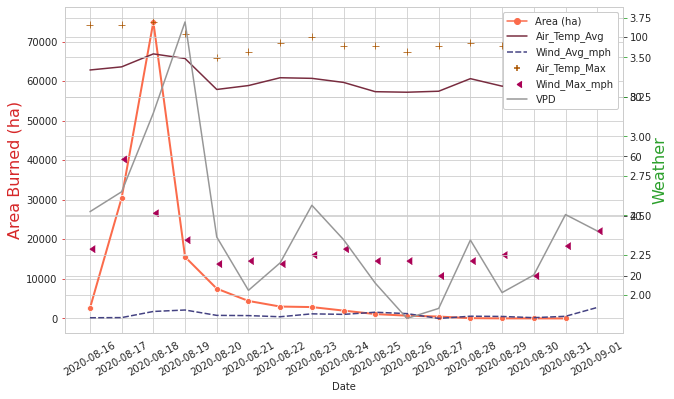

In [ ]:
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True, 'framealpha':1})
sns.despine(offset=10, trim=True);

plot_options = {'labelrotation':30}

r_color = 'tab:red' # Area, Magnitude
g_color = 'tab:green' # Wind 
o_color = 'tab:orange' # Weather 

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_ylabel('Area Burned (ha)', fontsize=16, color=r_color)
ax1 = sns.lineplot(data = area_df_plot, markers=True, palette='Reds_r', linewidth = 2)
ax1.tick_params(axis='y', color=r_color)
ax1.tick_params(axis='x', **plot_options)
ax1.legend(loc='upper right') 

ax2 = ax1.twinx()
ax2.set_ylabel('Weather', fontsize=16, color=g_color)
ax2 = sns.lineplot(data = wind_df_plot, palette='icefire_r')
ax2 = sns.scatterplot(data = maxWeather_df_plot, 
                      palette='brg_r', 
                      markers=['+', 4],
                      s=50)
ax2.legend(loc='upper right') 

ax3 = ax1.twinx()
ax3 = sns.lineplot(data = weather_df_plot, palette='Greys_r')
ax3.tick_params(axis='y', color=g_color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right', framealpha=1)

fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.png', dpi=400)

Take Daily Average i.e. Values During DayTime 6am to 6pm 

### Merge RAWS Daily w/ Fire Perimeter 

In [ ]:
# add datetime, round down time 
# merge hectare with datetime as new column 
fire_nm = 'Woolsey'
fire_yr = '2018'

# RAWS 
day_raws_df = getDailyRAWS_byFire(fire_nm, fire_yr)

# PERIMETER
fire_df = getPerimeter(fire_nm, fire_yr)

# DERIVED
derived_df = getDerivedDF(fl_path)
derived_df = derived_df[derived_df['FireName'] == fire_nm]

In [ ]:
derived_df = derived_df[['JulianDay', 'Date', 'Datetime', 'Area (ha)', 'DIR_WA', 'DIR_MaxDist', 'DIST_MEDSTD',
       'Magnitude (upperQ)', 'Magnitude (median)', 'FireName', 'Year',
       'NA_L3NAME', 'NA_L2NAME', 'ecoID', 'CONIFER', 'CONIFER_HA',
       'EXOTIC_HER', 'GRASSLAND', 'HARDWOOD', 'RIPARIAN', 'SHRUBLAND',
       'SPARSELY_V', 'URBAN', 'BARREN', 'DEVELOPED', 'AGRICULTURE',
       'deadfuelmoisture1000hr', 'minimumrelativehumidity','windfromdirection', 'windspeed',
       'meanvaporpressuredeficit']]

In [ ]:
fire_df['Time'] = fire_df['Time_Max'].astype('str').str.zfill(4)
fire_df['Time'] = fire_df['Time'] .map(lambda x: str(x)[:2] + ':00:00')
fire_df = fire_df.replace({'Time': '24:00:00'}, '23:00:00')
fire_df['Datetime'] = fire_df['Date'].str.cat(fire_df['Time'],sep=" ")  
fire_df['Datetime'] =  pd.to_datetime(fire_df['Datetime'] , format='%Y-%m-%d %H:%M:%S')

In [ ]:
# day_raws_df['Datetime']=  pd.to_datetime(day_raws_df['Datetime'], format='%Y-%m-%d %H:%M:%S')

# fire_df['Datetime'] =  fire_df['Datetime'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
# fire_df['Date'] =  fire_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))

merged_rim_df = pd.merge(day_raws_df, fire_df, how='left', on='Date')
merged_rim_df = pd.merge(merged_rim_df, derived_df, how='left', on='Date')

In [ ]:
merged_rim_df['Date']=  pd.to_datetime(merged_rim_df['Date'], format='%Y-%m-%d')
merged_rim_df['Interagency (ha)'] = merged_rim_df['Area (ha)_x'] / 1000 

In [ ]:
merged_rim_df = merged_rim_df.rename(columns={ 'VPD': 'Vapor Pressure Deficit (kPa)',
                                              'windspeed': 'GRID Wind Velocity (mph)', 
                                              'Magnitude (upperQ)' : 'Magnitude (km)',
                                              'Area (ha)_y': 'Area Burned (ha)',
                                              'Wind_Avg_mph': 'RAWS Wind Velocity (mph)',
                                              'Air_Temp_Max_Celcius' : 'Max Air Temp (C)',
                                              'Wind_Max_mph': 'Max Wind Velocity (mph)'                                             
                                              })

### Plot Wind

In [ ]:
wind_df_plot = merged_rim_df[[
 'Date',
 'GRID Wind Velocity (mph)',
 'RAWS Wind Velocity (mph)'
 ]]

wind_df_plot = wind_df_plot.set_index('Date')
wind_df_plot = wind_df_plot.sort_index()

area_df_plot = merged_rim_df[[
 'Date',
 'Interagency (ha)',
 'Area Burned (ha)',
 'Magnitude (km)'
 ]]
area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()


weather_df_plot = merged_rim_df[[
 'Date',
 'Vapor Pressure Deficit (kPa)'
 ]]

weather_df_plot = weather_df_plot.set_index('Date')
weather_df_plot = weather_df_plot.sort_index()


maxWeather_df_plot = merged_rim_df[[
 'Date',
 'Max Air Temp (C)',
 'Max Wind Velocity (mph)'
 ]]


maxWeather_df_plot = maxWeather_df_plot.set_index('Date')
maxWeather_df_plot = maxWeather_df_plot.sort_index()

<Figure size 432x288 with 0 Axes>

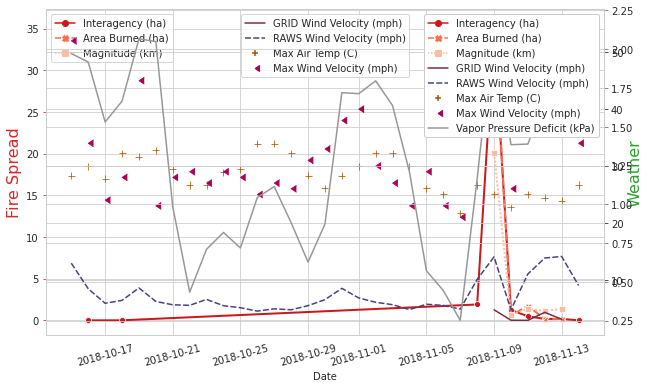

In [ ]:
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True, 'framealpha':1})
sns.despine(offset=10, trim=True);

plot_options = {'labelrotation':15}

r_color = 'tab:red' # Area, Magnitude
g_color = 'tab:green' # Wind 
o_color = 'tab:orange' # Weather 

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_ylabel('Fire Spread', fontsize=16, color=r_color)
ax1 = sns.lineplot(data = area_df_plot, markers=True, palette='Reds_r', linewidth = 2)
ax1.tick_params(axis='y', color=r_color)
ax1.tick_params(axis='x', **plot_options)

ax2 = ax1.twinx()
ax2.set_ylabel('Weather', fontsize=16, color=g_color)
ax2 = sns.lineplot(data = wind_df_plot, palette='icefire_r')
ax2 = sns.scatterplot(data = maxWeather_df_plot, 
                      palette='brg_r', 
                      markers=['+', 4],
                      s=50)

ax3 = ax1.twinx()
ax3 = sns.lineplot(data = weather_df_plot, palette='Greys_r')
ax3.tick_params(axis='y', color=g_color)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right', framealpha=1)


# fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.tif', dpi=400)
# fig.savefig(f'Figures/{fire_nm}_{fire_yr}_Wind_RAWSPlot.png', dpi=400)

### Daily Fuel

In [ ]:
fire_nm = 'Rim'
fire_yr = '2013'
derived_df = getDerivedDF(fl_path)
derived_df_fr = derived_df[derived_df['FireName'] == fire_nm]

fuel_df_plot = derived_df_fr[[
 'Date',
 'CONIFER', 'CONIFER_HA', 'EXOTIC_HER', 'GRASSLAND', 'HARDWOOD',
 'RIPARIAN', 'SHRUBLAND', 'SPARSELY_V', 'URBAN', 'BARREN', 'DEVELOPED',
 'AGRICULTURE']]

fuel_df_plot = fuel_df_plot.set_index('Date').fillna(0)
fuel_df_plot = fuel_df_plot.sort_index()


area_df_plot = derived_df_fr[[
 'Date',
 'Area (ha)',
 'Magnitude (upperQ)', 
 'Magnitude (median)'
 ]]

area_df_plot = area_df_plot.set_index('Date')
area_df_plot = area_df_plot.sort_index()

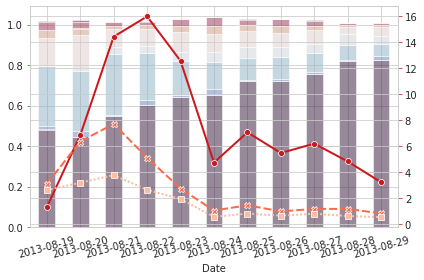

In [ ]:
#fig, ax1 = plt.subplots(figsize=(10,6))
plot_options = {'labelrotation':15}
sns.set_style('whitegrid')


color = 'tab:green'
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Fuel (%) ', fontsize=16, color=color)
ax1 = fuel_df_plot.plot(kind='bar',stacked=True,legend=False, cmap='twilight_shifted', alpha=0.5)
ax1.tick_params(axis='y', color=color)
ax1.tick_params(axis='x', **plot_options)


ax2 = ax1.twinx()
color = 'tab:red'
#ax2.set_ylabel('Fire Spread', fontsize=16, color=color)
ax2 = sns.lineplot(data = area_df_plot, markers=True, legend=False, palette='Reds_r', linewidth = 2)
ax2.tick_params(axis='y', color=color)

# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2 , labels + labels2 , bbox_to_anchor=(1.20, 1.05), framealpha=1)

plt.tight_layout()
plt.savefig(f'Figures/{fire_nm}_{fire_yr}_Fuelplot.png', dpi=400)

## Largest 25 Percentile Fires

In [ ]:
outPath = '/content/drive/My Drive/FireDrivers_Paper/FinalCSV_Info'
derived_df = pd.read_csv(os.path.join(outPath, 'FireInfoVar_Final.csv'), index_col=None)

In [ ]:
derived_df['YearJD'] = derived_df['Year'].astype('str').str.cat(derived_df['JulianDay'].astype('str'),sep="")  
derived_df['Date'] = pd.to_datetime(derived_df['YearJD'], format= '%Y%j')
derived_df['Date'] =  derived_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
derived_df['Datetime'] = derived_df['Date'] + ' 23:00:00'
derived_df = derived_df[derived_df['Area (ha)'] != 0]
derived_df['Area (ha)'] = np.log(derived_df['Area (ha)'])

In [ ]:
raws_csv_list = lstFiles(f"data/Final_CSV", '.csv')
combined_csv = pd.concat([pd.read_csv(f) for f in raws_csv_list ])

In [ ]:
combined_csv = combined_csv[combined_csv['Date'].notna()]
combined_csv['Date'] = combined_csv['Date'].astype('int64')

In [ ]:
filt_raws_daily = getDailyRAWS(combined_csv) #[(combined_csv['Fire'].isin(top25_firenm))]

# filt_raws['Date'] = pd.to_datetime(filt_raws['Datetime'], format= '%Y-%m-%d %H:%M:%S')
# filt_raws['Date'] =  filt_raws['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# filt_raws_daily = filt_raws.groupby(by=['Date', 'Fire']).mean().reset_index()

In [ ]:
# response var: 0
# topo: 1 
# weather : 2 
# fuel : 3 
# wind : 4
# VPD : 5
# Temp : 6

var_list = {  
 'Aspect_x': 1,
 'CBD': 3,
 'CONIFER': 3,
 'CONIFER_HA': 3,
 'DEM': 1,
 'EVI': 3,
 'EXOTIC_HER': 3,
 'FBFM1': 3,
 'FBFM10': 3,
 'FBFM11': 3,
 'FBFM12': 3,
 'FBFM2': 3,
 'FBFM3': 3,
 'FBFM4': 3,
 'FBFM5': 3,
 'FBFM6': 3,
 'FBFM7': 3,
 'FBFM8': 3,
 'FBFM9': 3,
 'FFWI': 2,
 'GRASSLAND': 3,
 'HARDWOOD': 3,
 'MaxNDVI': 3,
 'NDMI': 3,
 'NDMIDelta': 3,
 'NDVI': 3,
 'RIPARIAN': 3,
 'SHRUBLAND': 3,
 'SPARSELY_V': 3,
 'Slope': 1,
#  'URBAN': 3,
 'VALUE_108': 3,
 'VALUE_109': 3,
 'VALUE_110': 3,
 'VALUE_111': 3,
 'VALUE_112': 3,
#  'VALUE_1': 1,
#  'VALUE_2': 1,
#  'VALUE_3': 1,
#  'VALUE_4': 1,
#  'VALUE_5': 1,
 'burningindexg': 2,
 'deadfuelmoisture1000hr': 2,
 'deadfuelmoisture100hr': 2,
 'energyreleasecomponent': 2,
 'maximumairtemperature': 6,
 'maximumrelativehumidity': 2,
 'meanvaporpressuredeficit': 5,
 'minimumairtemperature': 2,
 'minimumrelativehumidity': 2,
 #'precipitationamount': 2,
 'referenceevapotranspirationalfalfa': 2,
 'referenceevapotranspirationgrass': 2,
 'specifichumidity': 2,
 'srad': 2,
 'surfacedownwellingshortwavefluxinair': 2,
 'tmax': 6,
 'tmin': 6,
 #'windfromdirection': 2,
 'windspeed': 4,
 'BARREN': 3,
 'shortHeight': 3,
 'medShortHeight': 3,
 'medHeight': 3,
 'Total_Solar_Rad': 2,
 'Wind_Avg_mph': 4,
 #'Wind_Dir_Deg': 2,
 'Wind_Max_mph': 4,
 'Air_Temp_Avg': 6,
 'Air_Temp_Max': 6,
 'Fuel_Temp_Avg': 2,
 'Fuel_Moist_Per': 2,
 'Rel_Hum_Per': 2,
 'VPD' : 5,
 #'Dew_Point_Deg': 2,
 #'Wet_Bulb': 2
 }

In [ ]:
def updateEcoNames(merged_rim_df):
  merged_rim_df.loc[merged_rim_df.ecoID == 5, 'NA_L3NAME'] = "Northern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 11, 'NA_L3NAME'] = "Southern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 8, 'NA_L3NAME'] = "Southern/Baja"
  merged_rim_df.loc[merged_rim_df.ecoID == 2, 'NA_L3NAME'] = "Southern/Baja"
  merged_rim_df.loc[merged_rim_df.ecoID == 2, 'ecoID'] = 8
  merged_rim_df.loc[merged_rim_df.ecoID == 1, 'NA_L3NAME'] = "Northern Coastal Sage"
  merged_rim_df.loc[merged_rim_df.ecoID == 1, 'ecoID'] = 5
  merged_rim_df.loc[merged_rim_df.ecoID == 0, 'NA_L3NAME'] = "Klamath Mountains"
  merged_rim_df.loc[merged_rim_df.ecoID == 0, 'ecoID'] = 7
  merged_rim_df.loc[merged_rim_df.ecoID == 12, 'NA_L3NAME'] = "Cascades"
  merged_rim_df.loc[merged_rim_df.ecoID == 12, 'ecoID'] = 3
  return merged_rim_df

In [ ]:
def get_correlation(filt_df, x, response_Var, var_list):
  for key in var_list: 
    df = filt_df[filt_df[x] == key]
    corr_val = df[response_Var].corr(df['value'])
    eco_region.append(ecoID)
    ind.append(ecounique)
    var_nm.append(key)
    r_val.append(abs(corr_val))
    class_val.append(var_list[key])
    hue_val.append(q)

In [ ]:
eco_region = []
r_val = []
var_nm = [] 
class_val = []
hue_val = []
ind = []

response_Var = 'Magnitude (upperQ)'

for i in range(0, 90 + 1, 5): #range(0, 100 + 1, 14)
  q = i/100
  Top25_area_val = derived_df[response_Var].quantile(q)
  top25_area = derived_df[derived_df[response_Var] >= Top25_area_val].reset_index()
  merged_rim_df = pd.merge(top25_area, filt_raws_daily, how='left', left_on=['Date', 'FireName'], right_on=['Date', 'Fire'])
  merged_rim_df = updateEcoNames(merged_rim_df)
  ecoID_List = merged_rim_df['NA_L3NAME'].unique().tolist()
  ecoID_name = [s + f'_{str(i)}' for s in ecoID_List]
  ecoID, ecounique = ('ALL', 'ALL')
  for ecoID, ecounique in list(zip(ecoID_List, ecoID_name)): 
    df  = merged_rim_df[(merged_rim_df['NA_L3NAME'] == ecoID)]
    filt_df = pd.melt(df, id_vars=['FireName', 'JulianDay', 'Area (ha)', 'Magnitude (upperQ)'], value_vars=list(var_list.keys())).dropna()
    get_correlation(filt_df, 'variable', response_Var, var_list)

In [ ]:
corr_df = pd.DataFrame({'ind' : ind, 'Ecoregion': eco_region, 'Quantile': hue_val, 'Variable Name': var_nm, 'r-value': r_val, 'Variable Type': class_val})
corr_df = corr_df.dropna()

In [ ]:
corr_df

## Correlate by Fire

In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
corr_df = corr_df[['ind', 'Ecoregion','Quantile', 'Variable Name', 'r-value','Variable Type']]
corr_df = corr_df.loc[corr_df.groupby(['ind', 'Ecoregion', 'Variable Type', 'Quantile'])['r-value'].idxmax()].set_index(['ind']).reset_index()
corr_df = corr_df.sort_values(by=['Quantile'])

In [ ]:
class_val_dict = {
1 : 'Topography',
2 : 'Weather',
3 : 'Fuel' ,
4 : 'Wind' ,
5 : 'VPD' ,
6 : 'Temperature'}

corr_df = corr_df.replace({"Variable Type": class_val_dict})

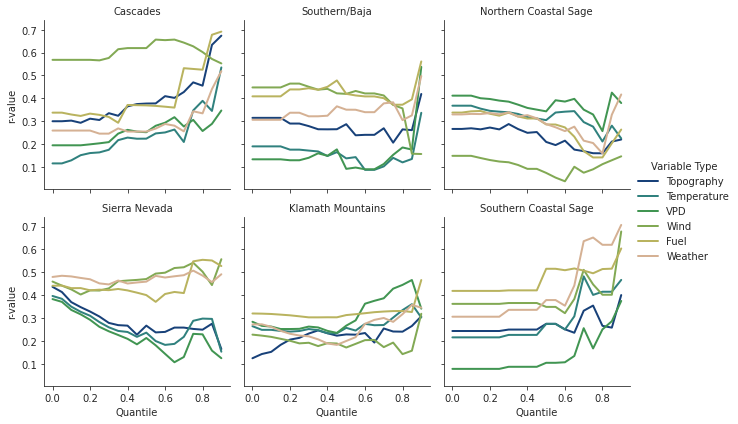

In [ ]:
import seaborn as sns
sns.set_style('ticks')
g = sns.FacetGrid(corr_df, col="Ecoregion", hue="Variable Type", col_wrap=3, palette='gist_earth')
g = (g.map(plt.plot, "Quantile", "r-value", linewidth = 2)
     .add_legend()
     .set_titles("{col_name}"))

plt.savefig(f'Figures/quantile_correlation_facetbyEco_Magnitude.png', dpi=400)

In [ ]:
x_y_z = corr_df.pivot(index='Ecoregion', columns='Variable Type', values=['r-value', 'Variable Name'])
x_y_z.columns = ['ind', 'Topography', 'Weather', 'Fuel', 'Wind', 'VPD', 'Temp_max', 'Topo_Var', 'Weather_Var', 'Fuel_Var', 'Wind_Var', 'VPD_Var', 'Temp_Var']
x_y_z[['Ecoregion','Quantile']] = x_y_z.ind.str.split("_",expand=True) 

In [ ]:
corr_df

In [ ]:
x_y_z

In [ ]:
import plotly.express as px
df = px.data.election()
x_y_z['hue_val'] = x_y_z.hue_val.astype('int64')
fig = px.scatter_3d(x_y_z, x="Topography", y="Wind", z="Fuel", hover_name="eco_region", color="hue_val",
                  symbol="eco_region", color_continuous_scale='Sunset', 
                  symbol_map={'Cascades':'square', 'Klamath Mountains': 'circle-open', 'Northern Coastal Sage': 'diamond',
                                 'Sierra Nevada':'circle', 'Southern/Baja': 'diamond-open', 'Southern Coastal Sage': 'cross'})
fig.update_layout(showlegend=False)
fig.show()

### Ternary Plot

In [ ]:
!  pip install python-ternary

In [ ]:
import ternary

import plotly.express as px
df = px.data.election()
fig = px.scatter_ternary(x_y_z, a='Topo_p', b='Wind_p', c='Fuel_p',  hover_name="eco_region", color="eco_region", symbol="hue_val",
                   size_max=100, color_discrete_map = {'Topo': "blue", 'Weather': "green", 'Fuel':"red"} )
fig.show()